# Wrangling & Analyzing Twitter Data

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import tweepy

from datetime import datetime
from functools import reduce
from collections import Counter

% matplotlib inline

# 1. Gathering Data
---
First, I need to gather all the data required to complete this project.
> Load the data in variables for future use :
>> * Enhanced twitter archive
>> * Image predictions
>> * Query Twitter API with the given tweet ids in the enhanced twitter archive

In [2]:
#Load the enhanced data I was given
weRateDogsArchive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#The given url where image predictions file are stored in
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
#Requesting the image predictions file from udcity server
getResponse = requests.get(URL)
with open(os.path.join('image_predictions.tsv'), mode = 'wb') as file:
    file.write(getResponse.content)

In [4]:
#Load the downloaded prediction file from the previous step
#TSV files are sperated by tabs hence we used sep \t
imagesPredictions = pd.read_csv('image_predictions.tsv', sep = '\t')

In [5]:
#Intializing the twitter api with my given keys
api_key = ''
api_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [6]:
#Using twitter API to download tweet status with their tweet ids from the given we rate dogs archive
idsOfTweets = list(weRateDogsArchive['tweet_id'])

#tweet data used for storing all the tweets status given from twitter apis
tweet_data = []
#tweet id success used to store all the retrived tweets status successfully
tweet_id_success = []
#tweet id missing used to store all the unsuccessfully quired tweets eg; tweet were delted
tweet_id_missing = []
for tweet_id in idsOfTweets:
    try:
        data = api.get_status(tweet_id, 
                              tweet_mode='extended',
                              wait_on_rate_limit = True,
                              wait_on_rate_limit_notify = True)
        tweet_data.append(data)
        tweet_id_success.append(tweet_id)
    except:
        tweet_id_missing.append(tweet_id)

Rate limit reached. Sleeping for: 734
Rate limit reached. Sleeping for: 734


In [7]:
#Missing tweet ids from the API
tweet_id_missing

[888202515573088257,
 873697596434513921,
 872668790621863937,
 872261713294495745,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 856602993587888130,
 845459076796616705,
 844704788403113984,
 842892208864923648,
 837012587749474308,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 775096608509886464,
 770743923962707968,
 754011816964026368,
 680055455951884288]

In [8]:
#Writing Twitter JSON which we will use to create pandas DataFrame 
with open('tweet_data_json.txt', mode = 'w') as file:
    json.dump(tweet_data, file)

In [15]:
#Load the Twitter API data from the json file
apiTweetData = pd.read_json('tweet_data_json.txt')
#Concatenate tweet ids with their retrived data from the API
apiTweetData['tweet_id'] = tweet_id_success
#Show only the data we are intersted in wragling only as noted in the project key features
apiTweetData = twitter2[['tweet_id', 'favorite_count', 'retweet_count']]
apiTweetData

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37611,8199
1,892177421306343426,32319,6065
2,891815181378084864,24353,4011
3,891689557279858688,40935,8362
4,891327558926688256,39145,9052
5,891087950875897856,19679,3007
6,890971913173991426,11510,1986
7,890729181411237888,63445,18219
8,890609185150312448,27066,4124
9,890240255349198849,31011,7122


# 2. Assessing data
---
Now I have got 3 diffrent data sources that I need to assess and understand the realtion between them.

1. twitter-archive-enhanced.csv which is loaded in **weRateDogsArchive** variable.
2. image_predictions.tsv which is loaded in **imagesPredictions** variable.
3. tweet_data_json.txt which is loaded in **apiTweetData** variable.


### 1. Starting with twitter-archive-enhanced.csv**

In [16]:
#lets have a random sample of 5 rows to observe
weRateDogsArchive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
490,813812741911748608,NaN,NaN,2016-12-27 18:24:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Gary, Carrie Fisher's dog. Idk what I can...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/813812741...,14,10,Gary,None,None,None,None
2109,670449342516494336,NaN,NaN,2015-11-28 03:49:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Vibrant dog here. Fabulous tail. Only 2 legs t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670449342...,5,10,None,None,None,None,None
1201,716447146686459905,NaN,NaN,2016-04-03 02:08:05 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Ozzy. He's acrobatic af. Legendary pup...,NaN,NaN,NaN,https://vine.co/v/eMmXVPn5eQK,13,10,Ozzy,None,None,pupper,None
85,876120275196170240,NaN,NaN,2017-06-17 16:52:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Venti, a seemingly caffeinated puppoccino...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/876120275...,13,10,Venti,None,None,None,None
1841,675878199931371520,NaN,NaN,2015-12-13 03:21:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Ok, I'll admit this is a pretty adorable bunny...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/675878199...,11,10,None,None,None,None,None


What I can cnosider valuable in this data are:
---
* tweet_id which we can build a relation with the data we retrived from the API
* soruce from what I understand it's the device were used to tweet with
* rating_numerator and rating_denominator which can use to get the dogs ratings
* name and nicknames "doggo, floofer, pupper and puppo"
* text the tweet caption 

In [18]:
#lets have a look into the index range, number of columns and the datatypes of the data of each column
weRateDogsArchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

We can confirm that some rows have null values.
But none of what I consider valuable got null values.

---
### Checking for the unqiue rows and their numbers

In [19]:
#lets have a look into tweet sources
weRateDogsArchive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

We can confirm that most of the tweets were tweeted twitter app from iPhone devices.

In [20]:
weRateDogsArchive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

Woah... wait a second.

According to the project overview the rating numerator should always greater than 10 Because "they're good dogs Brent."

This point should be kept in mind when we reach cleaning the dataset phase.

I don't want to be like brent but also we might neglect the numbers which is greater than 20 because it might be outliers.

In [21]:
#Time to check the denominator
weRateDogsArchive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

Well same goes here according to the project overview the denominator is always 10 anything beside that is noise that we will take care in data cleaning phase.

In [25]:
weRateDogsArchive['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [26]:
weRateDogsArchive['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [27]:
weRateDogsArchive['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [28]:
weRateDogsArchive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

Well seems that everything is in order with our cute little dogs nicknames.

In [30]:
#checking dogs name for unreasonable assigned names
weRateDogsArchive['name'].value_counts()

None         745
a             55
Charlie       12
Lucy          11
Cooper        11
Oliver        11
Lola          10
Penny         10
Tucker        10
Bo             9
Winston        9
Sadie          8
the            8
Daisy          7
an             7
Bailey         7
Toby           7
Buddy          7
Dave           6
Scout          6
Bella          6
Koda           6
Milo           6
Oscar          6
Leo            6
Stanley        6
Jack           6
Rusty          6
Jax            6
Sammy          5
            ... 
Herb           1
Kingsley       1
Rueben         1
Comet          1
Rose           1
Lambeau        1
Kobe           1
Scruffers      1
Kial           1
Travis         1
Ronnie         1
Howie          1
Staniel        1
Wesley         1
Kody           1
Storkson       1
Bruno          1
Severus        1
Dotsy          1
Kulet          1
Blakely        1
Clarkus        1
Goose          1
Hazel          1
Filup          1
Edd            1
Dante          1
Crimson       

We can see that there is some dogs that have unreasonable names like "a, my, an" we will check these names in data cleaning phase.

---

### 2. image_predictions.tsv
I will use the same method I used above to asses the image_predictions dataset

In [31]:
imagesPredictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1136,728760639972315136,https://pbs.twimg.com/media/Ch0T71OWMAA4yIw.jpg,1,Pembroke,0.939134,True,Cardigan,0.054336,True,Chihuahua,0.005590,True
289,671163268581498880,https://pbs.twimg.com/media/CVBzbWsWsAEyNMA.jpg,1,African_hunting_dog,0.733025,False,plow,0.119377,False,Scottish_deerhound,0.026983,True
1735,821765923262631936,https://pbs.twimg.com/media/C2d_vnHWEAE9phX.jpg,1,golden_retriever,0.980071,True,Labrador_retriever,0.008758,True,Saluki,0.001806,True
1689,815639385530101762,https://pbs.twimg.com/media/C1G7sXyWIAA10eH.jpg,1,German_shepherd,0.817953,True,Norwegian_elkhound,0.140007,True,malinois,0.024821,True
1010,709409458133323776,https://pbs.twimg.com/media/CdhUIMSUIAA4wYK.jpg,1,Shetland_sheepdog,0.797450,True,collie,0.054055,True,keeshond,0.031673,True


In [32]:
imagesPredictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [35]:
imagesPredictions['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
web_site                      19
Cardigan                      19
Maltese_dog                   18
teddy                         18
Shetland_sheepdog             18
Eskimo_dog                    18
beagle                        18
Shih-Tzu                      17
Lakeland_terrier              17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

**The majority of p1 which waspredicted by the nueral network was golden_retriever.**

In [36]:
imagesPredictions['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
Siberian_husky                     33
miniature_poodle                   33
beagle                             28
Pembroke                           27
collie                             27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
American_Staffordshire_terrier     21
Pekinese                           21
Samoyed                            20
malinois                           20
toy_terrier                        20
miniature_pinscher                 20
chow                               20
Boston_bull                        19
Norwegian_elkhound                 19
Staffordshir

**The majority of p2 which waspredicted by the nueral network was Labrador_retriever.**

### 3. tweet_data_json.txt
I will use the same method I used above to asses the tweet_data_json dataset

In [37]:
apiTweetData.sample(5)

,tweet_id,favorite_count,retweet_count
1675,681297372102656000,3322,1014
1237,710609963652087808,4955,2473
647,790987426131050500,10456,2312
449,817502432452313088,0,3658
2097,670427002554466305,522,166


In [38]:
apiTweetData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 3 columns):
tweet_id          2337 non-null int64
favorite_count    2337 non-null int64
retweet_count     2337 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


# Cleaning Data
After we gathered and assessed the given data we now can determine what quality and tidiness issues we found and what we will fix.

**(Note: not all the issues will be fixed 8 quailty issues and 2 tidiness only will be addressed)**

### Quality Issues
>1. twitter-archive-enhanced.csv **weRateDogsArchive**
>>1. According to the project key features we do not need retweets so we will remove the retweets (ie. rows where retweeted_status_id and retweeted_status_user_id have a number instead of NaN)
>>2. I have decided what columns that I will by using for analysis in Assising data phase, so I will remove the columns that I will not be using.
>>3. In assising data when I was trying to figure the unique counts of the numerator I found that some rows violate the rating rules (eg; some ratings with decimals such as 13.5/10, 9.5/10 have been incorrectly exported as 5/10 (in addition to other numbers with decimals such as 11.26 and 11.27)..
>>4. Same goes for the denominator column.
>>5. Name has values that are the string "None" instead of NaN
>>6. Timestamp and retweeted_status_timestamp are currently of type 'object' instead of datetime
>>7. Some names are inaccurate such as "a", "an" and many more maybe because the method that were used to extract the names took the word after sentences like "This is ......" and "Here is ......" which made some noisy data.
>>8. It took me some time to get the idea behind their rating system because it's not unstandardized so I suppouse reading those rating in form of decimal is way better than reading 2 numbers dividing each others, so I will add new column for rating that caclute this equation.

>2. image_predictions.tsv **imagesPredictions**
>>1. p1, p2, and p3 sperated by underscore instead of space
>>2. There are 2356 tweets weRateDogsArchive and 2075 rows in imagesPredictions which means some data maybe missing.

>3. tweet_data_json.txt **apiTweetData**.
>>1. There are 19 missing tweets that we caught while querying twitter API, maybe there were deleted or wrongly stored on our enhanced dataset.

### Tidiness Issues
>1. twitter-archive-enhanced.csv **weRateDogsArchive**
>>1. Dog stage "nicknames" are sperated across 4 columns instead of one.

>2. image_predictions.tsv **imagesPredictions**
>>1. This dataset can be merged "joined" with **weRateDogsArchive** because they both refer to the same tweet.

>3. tweet_data_json.txt **apiTweetData**
>>1. Same goes here it should be merged with **weRateDogsArchive**.

#### Note the format I will be using to solve the problem will be like the following:
* ##### Define : here I will mention the issue from the issues above with it's type and what section.
* ##### Code : here I will translate what I had mentioned in the issue into python code.
* ##### Test : here I will test the results of my code to check that the issue were solved.

---

#### First, I will make copy of the acquired data sets. I don't want to keep restarting the notebook if I messed up the only source of data I have.

In [65]:
weRateDogsArchive_clean = weRateDogsArchive.copy()
imagesPredictions_clean = imagesPredictions.copy()
apiTweetData_clean = apiTweetData.copy()

### Define
#### Tidiness Issues 1. A.

In [66]:
#Before editing the enhanced archive
weRateDogsArchive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### Code and Test

In [67]:
#Extract dog stages from 'text' column into new 'dog_stage' column 
weRateDogsArchive_clean['dog_stage'] = weRateDogsArchive_clean['text'].str.extract('(doggo|floofer|pupper|puppo)')
#Check that a random sample of dog_stage are similar to that which was previously extracted
weRateDogsArchive_clean[['dog_stage','doggo', 'floofer', 'pupper', 'puppo']].sample(15)

,dog_stage,doggo,floofer,pupper,puppo
2274,NaN,None,None,None,None
1127,NaN,None,None,None,None
1295,NaN,None,None,None,None
1537,NaN,None,None,None,None
94,puppo,None,None,None,puppo
135,pupper,None,None,pupper,None
502,NaN,None,None,None,None
834,NaN,None,None,None,None
1003,NaN,None,None,None,None
1304,pupper,None,None,pupper,None


In [68]:
# Drop doggo, floofer, pupper, and puppo unnecessary columns
weRateDogsArchive_clean = weRateDogsArchive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [69]:
#Check for presence of 'dog_stage" and absence of 'doggo', 'floofer', 'pupper', and 'puppo'
weRateDogsArchive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     399 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 257.8+ KB


### Define
#### Tidiness Issues 2. A. and 3. A.

#### Code and Test

In [70]:
#Merge the weRateDogsArchive_clean, apiTweetData, and imagesPredictions datasets with 'tweet_ids'
dfs = [weRateDogsArchive_clean, apiTweetData_clean, imagesPredictions_clean]
weRateDogsArchive_clean = reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), dfs)
#Checking everything successfully merged
weRateDogsArchive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065 entries, 0 to 2064
Data columns (total 27 columns):
tweet_id                      2065 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2065 non-null object
source                        2065 non-null object
text                          2065 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null object
expanded_urls                 2065 non-null object
rating_numerator              2065 non-null int64
rating_denominator            2065 non-null int64
name                          2065 non-null object
dog_stage                     338 non-null object
favorite_count                2065 non-null int64
retweet_count                 2065 non-null int64
jpg_url                       2065 non-null object
img_num                       2065 non

#### Quality Issues
Since all the data were merged we will work on weRateDogsArchive_clean only. 

---
### Define
##### Removing re-tweets 1. A.

#### Code

In [71]:
# Keep columns where 'retweeted_status_id' is NaN
weRateDogsArchive_clean = weRateDogsArchive_clean[np.isnan(weRateDogsArchive_clean.retweeted_status_id)]

# Check info to determine all there are no non-null entries for
# 'retweeted_status_id', 'retweeted_status_user_id' and 
# 'retweeted_status_timestamp'
print(weRateDogsArchive_clean.info())

# Remove 'retweeted_status_id', 'retweeted_status_user_id' and 
# 'retweeted_status_timestamp' columns
weRateDogsArchive_clean = weRateDogsArchive_clean.drop(['retweeted_status_id', 
                        'retweeted_status_user_id', 
                        'retweeted_status_timestamp'], 
                       axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 2064
Data columns (total 27 columns):
tweet_id                      1990 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1990 non-null object
source                        1990 non-null object
text                          1990 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1990 non-null object
rating_numerator              1990 non-null int64
rating_denominator            1990 non-null int64
name                          1990 non-null object
dog_stage                     326 non-null object
favorite_count                1990 non-null int64
retweet_count                 1990 non-null int64
jpg_url                       1990 non-null object
img_num                       1990 non-nu

#### Test

In [73]:
weRateDogsArchive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 2064
Data columns (total 24 columns):
tweet_id                 1990 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1990 non-null object
source                   1990 non-null object
text                     1990 non-null object
expanded_urls            1990 non-null object
rating_numerator         1990 non-null int64
rating_denominator       1990 non-null int64
name                     1990 non-null object
dog_stage                326 non-null object
favorite_count           1990 non-null int64
retweet_count            1990 non-null int64
jpg_url                  1990 non-null object
img_num                  1990 non-null int64
p1                       1990 non-null object
p1_conf                  1990 non-null float64
p1_dog                   1990 non-null bool
p2                       1990 non-null object
p2_conf                  1990

### Define
####  Remove the columns that I will not be using. 1. B.

In [74]:
#Show all column names
weRateDogsArchive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'favorite_count',
       'retweet_count', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

#### Code and Test

In [76]:
#Drop columns to make dataframe easier to read through
weRateDogsArchive_clean.drop(['in_reply_to_status_id', 
              'in_reply_to_user_id',
              'source',
              'img_num'], axis=1, inplace=True)

#Allow all columns and text to be shown 
pd.set_option('display.max_columns', None)

#show columns after deleteing the undesired ones
weRateDogsArchive_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage', 'favorite_count',
       'retweet_count', 'jpg_url', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

### Define
#### Removing rating rules that violate WeRateDogs standards . 1. C. and 1. D.
Find all instances of ratings that contained decimals and replace the numerator values with the correct values from text column.

In [77]:
#Obtain all text, indices, and ratings for tweets that contain a decimal in the numerator of rating
ratings_with_decimals_text = []
ratings_with_decimals_index = []
ratings_with_decimals = []

for i, text in weRateDogsArchive_clean['text'].iteritems():
    if bool(re.search('\d+\.\d+\/\d+', text)):
        ratings_with_decimals_text.append(text)
        ratings_with_decimals_index.append(i)
        ratings_with_decimals.append(re.search('\d+\.\d+', text).group())

# Print the text to confirm presence of ratings with decimals        
ratings_with_decimals_text

['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
 "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
 "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
 'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']

In [78]:
# Print the index of text with decimal ratings to know which row that will be replaced
ratings_with_decimals_index

[40, 551, 607, 1444]

#### Code and Test

In [79]:
# Change contents of 'rating_numerator' based on info found.
weRateDogsArchive_clean.loc[ratings_with_decimals_index[0],'rating_numerator'] = float(ratings_with_decimals[0])
weRateDogsArchive_clean.loc[ratings_with_decimals_index[1],'rating_numerator'] = float(ratings_with_decimals[1])
weRateDogsArchive_clean.loc[ratings_with_decimals_index[2],'rating_numerator'] = float(ratings_with_decimals[2])
weRateDogsArchive_clean.loc[ratings_with_decimals_index[3],'rating_numerator'] = float(ratings_with_decimals[3])

In [81]:
weRateDogsArchive_clean['rating_numerator'].value_counts()

12.00      449
10.00      418
11.00      396
13.00      259
9.00       151
8.00        95
7.00        52
14.00       35
5.00        32
6.00        32
3.00        19
4.00        16
2.00         9
1.00         5
0.00         2
24.00        1
9.75         1
84.00        1
13.50        1
143.00       1
420.00       1
50.00        1
80.00        1
45.00        1
60.00        1
44.00        1
144.00       1
88.00        1
11.26        1
165.00       1
11.27        1
1776.00      1
99.00        1
121.00       1
204.00       1
Name: rating_numerator, dtype: int64

In [92]:
#Now remove the numerator lower than 10 "Noisy data"
weRateDogsArchive_clean = weRateDogsArchive_clean[(weRateDogsArchive_clean.rating_numerator >= 10) & (weRateDogsArchive_clean.rating_numerator <= 20)]
weRateDogsArchive_clean['rating_numerator'].value_counts()

12.00    449
10.00    418
11.00    396
13.00    259
14.00     35
11.27      1
11.26      1
13.50      1
Name: rating_numerator, dtype: int64

In [93]:
#Do the same for denominator for outlires
weRateDogsArchive_clean['rating_denominator'].value_counts()

10    1560
Name: rating_denominator, dtype: int64

Now the rating_numerator and rating_denominator are in good shape.

### Define
#### Fixing the name issues. 1. G. 1. E.

In [95]:
#Find all names that start with a lowercase letter because names are stored with a Uppercase first letter
lowercase_names = []
for row in weRateDogsArchive_clean['name']:
    if row[0].islower() and row not in lowercase_names:
        lowercase_names.append(row)
print(lowercase_names)

['such', 'a', 'quite', 'one', 'incredibly', 'very', 'my', 'not', 'his', 'just', 'getting', 'all', 'infuriating', 'an', 'actually', 'by', 'officially', 'the', 'light', 'space']


#### Code and Test

In [100]:
# Replace all names that start with a lowercase letter with a NaN
weRateDogsArchive_clean['name'].replace(lowercase_names, 
                        np.nan,
                       inplace = True)

# Replace all 'None's with a NaN
weRateDogsArchive_clean['name'].replace('None', 
                        np.nan,
                       inplace = True)
weRateDogsArchive_clean['name'].value_counts()

Charlie     10
Lucy        10
Cooper       9
Oliver       9
Tucker       8
Sadie        7
Winston      7
Penny        7
Daisy        6
Bo           6
Koda         6
Milo         5
Louis        5
Jax          5
Stanley      5
Leo          5
Bella        5
Toby         5
Lola         5
Bear         4
Sophie       4
Scout        4
Derek        4
Oscar        4
Rusty        4
Jack         4
Finn         4
Scooter      4
Duke         4
Chester      4
            ..
Ulysses      1
Jimison      1
Willy        1
Ralphé       1
Skittles     1
Dido         1
Tupawc       1
Kuyu         1
Bernie       1
Mollie       1
Zeus         1
Lipton       1
Kramer       1
Molly        1
Ken          1
Rumble       1
Buddah       1
Raphael      1
Cannon       1
Klein        1
Thor         1
Brady        1
Crumpet      1
Major        1
Chaz         1
General      1
Eleanor      1
Theo         1
Tedders      1
Beckham      1
Name: name, Length: 769, dtype: int64

### Define
#### Change timestamp from object into time datatype. 1. F.

In [103]:
weRateDogsArchive_clean['timestamp'].value_counts()

2016-02-26 04:48:02 +0000    1
2016-09-06 19:52:39 +0000    1
2016-12-05 17:31:15 +0000    1
2016-08-24 15:43:39 +0000    1
2017-03-06 01:26:54 +0000    1
2017-01-07 20:18:46 +0000    1
2017-06-30 23:47:07 +0000    1
2015-12-07 01:47:30 +0000    1
2016-11-14 01:18:12 +0000    1
2016-05-20 00:51:30 +0000    1
2017-06-06 00:01:46 +0000    1
2017-01-11 17:01:16 +0000    1
2016-03-29 00:12:05 +0000    1
2017-07-09 21:29:42 +0000    1
2016-04-01 15:46:52 +0000    1
2016-05-12 01:40:42 +0000    1
2017-07-24 00:19:32 +0000    1
2017-07-20 16:49:33 +0000    1
2016-06-27 16:08:30 +0000    1
2017-05-04 23:34:55 +0000    1
2015-11-28 02:25:32 +0000    1
2016-06-13 18:27:32 +0000    1
2016-03-04 03:13:11 +0000    1
2016-01-07 01:49:14 +0000    1
2017-02-22 01:14:30 +0000    1
2015-12-12 03:29:35 +0000    1
2016-02-11 03:02:54 +0000    1
2016-02-04 02:40:08 +0000    1
2017-03-16 00:00:07 +0000    1
2016-10-09 23:44:41 +0000    1
                            ..
2015-11-19 15:49:57 +0000    1
2017-02-

As we can notice timezone information is not needed because it's only stored with +0000 which does not give any information about the time zone.

#### Code and Test

In [105]:
#Remove the time zone information from 'timestamp' column
weRateDogsArchive_clean['timestamp'] = weRateDogsArchive_clean['timestamp'].str.slice(start=0, stop=-6)

In [109]:
#Change the 'timestamp' column to a datetime object
weRateDogsArchive_clean['timestamp'] = pd.to_datetime(weRateDogsArchive_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")
weRateDogsArchive_clean['timestamp'].value_counts()

2016-02-15 01:05:02    1
2017-03-11 22:51:24    1
2015-12-09 02:34:18    1
2017-02-06 17:02:17    1
2015-12-21 22:15:18    1
2016-12-12 00:29:28    1
2017-08-01 16:23:56    1
2016-04-04 17:53:31    1
2016-04-23 01:41:59    1
2015-12-27 22:37:04    1
2017-05-19 00:12:11    1
2016-05-27 01:47:23    1
2017-01-25 16:45:05    1
2017-05-15 19:14:50    1
2016-03-20 01:28:47    1
2016-10-31 21:00:23    1
2015-11-26 17:11:11    1
2017-07-03 00:11:11    1
2016-10-11 16:00:24    1
2015-12-07 17:38:09    1
2015-12-22 04:35:49    1
2017-07-11 00:00:02    1
2016-10-23 00:27:05    1
2016-03-15 21:24:41    1
2016-02-04 04:03:57    1
2017-02-18 17:00:10    1
2016-04-08 20:46:50    1
2017-04-23 23:01:59    1
2015-12-12 03:47:46    1
2016-06-13 21:16:49    1
                      ..
2015-12-02 03:40:57    1
2016-07-18 18:43:07    1
2015-11-16 01:22:45    1
2015-12-12 04:23:49    1
2017-01-06 17:33:29    1
2016-02-13 22:29:29    1
2016-02-10 02:14:42    1
2016-09-03 16:52:02    1
2016-03-13 23:24:56    1


#### Create rating column and calculate the ratings for better analyze 1. H.

In [112]:
# Calulate the value of 'rating'
weRateDogsArchive_clean['rating'] = weRateDogsArchive_clean['rating_numerator'] / weRateDogsArchive_clean['rating_denominator']

#Now we can drop the numerator and denominator columns
weRateDogsArchive_clean.drop(['rating_numerator', 
              'rating_denominator'], axis=1, inplace=True)

weRateDogsArchive_clean.sample(5)

,tweet_id,timestamp,text,expanded_urls,name,dog_stage,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating
399,813051746834595840,2016-12-25 16:00:16,This is Bauer. He had nothing to do with the c...,https://twitter.com/dog_rates/status/813051746...,Bauer,NaN,22144,7935,https://pbs.twimg.com/media/C0iKPZIXUAAbDYV.jpg,golden_retriever,0.914804,True,Labrador_retriever,0.083550,True,kuvasz,0.000453,True,1.3
292,828372645993398273,2017-02-05 22:40:03,This is Alexander Hamilpup. He was one of the ...,https://twitter.com/dog_rates/status/828372645...,Alexander,NaN,13113,3158,https://pbs.twimg.com/media/C374hb0WQAAIbQ-.jpg,malamute,0.663047,True,Eskimo_dog,0.207779,True,Tibetan_mastiff,0.040949,True,1.2
33,885167619883638784,2017-07-12 16:03:00,Here we have a corgi undercover as a malamute....,https://twitter.com/dog_rates/status/885167619...,NaN,NaN,21304,4238,https://pbs.twimg.com/media/DEi_N9qXYAAgEEw.jpg,malamute,0.812482,True,Siberian_husky,0.071712,True,Eskimo_dog,0.055770,True,1.3
78,874296783580663808,2017-06-12 16:06:11,This is Jed. He may be the fanciest pupper in ...,https://twitter.com/dog_rates/status/874296783...,Jed,pupper,25419,4000,https://pbs.twimg.com/media/DCIgSR0XgAANEOY.jpg,cocker_spaniel,0.437216,True,miniature_poodle,0.277191,True,toy_poodle,0.157402,True,1.3
1528,676946864479084545,2015-12-16 02:08:04,This pups goal was to get all four feet as clo...,https://twitter.com/dog_rates/status/676946864...,NaN,NaN,1753,394,https://pbs.twimg.com/media/CWT_lOQWUAAXPaY.jpg,Pekinese,0.752707,True,golden_retriever,0.055655,True,Great_Pyrenees,0.041018,True,1.2


---
## Exporting the cleaned data into csv file

In [114]:
weRateDogsArchive_clean.to_csv('twitter-archive-double-enhanced.csv')

---
## Analyzing the dataset for further understanding

#### Let's check dog rating against time
Checking dog rating against timestamp will give us a good overview about their rating and will answer question like: Do most dogs get 10/10 or they increased it overtime ?

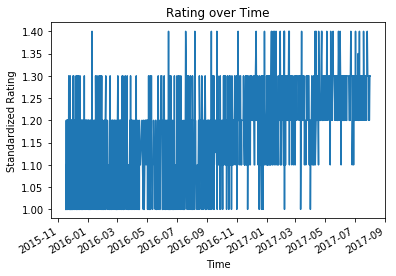

In [115]:
# Plot standardized ratings over time
weRateDogsArchive_clean.groupby('timestamp')['rating'].mean().plot(kind='line')
plt.title('Rating over Time')
plt.xlabel('Time')
plt.ylabel('Standardized Rating')
plt.show;

Observing this graph we can tell that they stopped giving dogs 10/10 and increased the numerator by MID 2017, and the super cutest dogs of all the time gaind the maximum of 14/10.

---

#### Checking Retweet count aganist time
Checking Retweets aganist timestamp will give us a good overview about their account activity and will answer questions like:
When is the most users interactivity with their tweeter account and what is the most retweet count they have reached ?

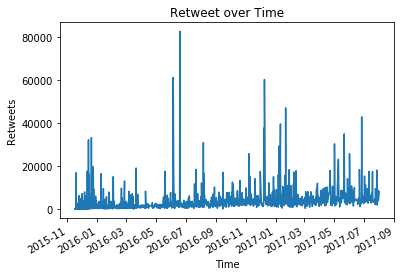

In [116]:
weRateDogsArchive_clean.groupby('timestamp')['retweet_count'].mean().plot(kind='line')
plt.title('Retweet over Time')
plt.xlabel('Time')
plt.ylabel('Retweets')
plt.show;

Observing this graph we can tell that the highest number of retweet they reached was 80k retweet and it was in 2016-07

---

#### Checking Favorite count aganist time
Checking Favorite aganist timestamp will give us a good overview about their account activity and will answer questions like:
When is the most users interactivity with their tweeter account and what is the most favorite count they have reached ?
Do Retweet and favorite count realte to each other in terms of the highest count over time ?

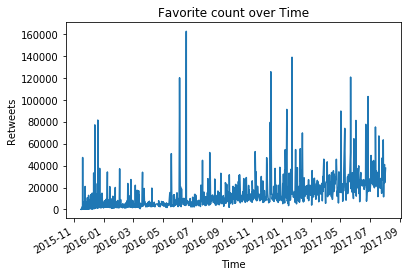

In [122]:
weRateDogsArchive_clean.groupby('timestamp')['favorite_count'].mean().plot(kind='line')
plt.title('Favorite count over Time')
plt.xlabel('Time')
plt.ylabel('Retweets')
plt.show;

Observing this graph we can tell that the highest number of favorite count they reached was 160k favorite and it was in 2016-07, and also it was the same time the retweet reached it's highest count all the time.

---

#### Checking Retweets aganist Favorite
Checking Retweets aganist Favorite will give us a good overview about the relation btween them and will give us an answer to the above question:
Do Retweet and Favorite count have a common relationship or it's just random ?

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


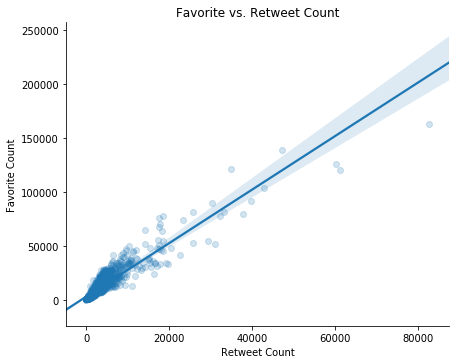

In [119]:
# Plot scatterplot of retweet vs favorite count
sns.lmplot(x= "retweet_count", 
           y= "favorite_count", 
           data= weRateDogsArchive_clean,
           size = 5,
           aspect= 1.3,
           scatter_kws= {'alpha':1/5})
plt.title('Favorite vs. Retweet Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

We can notice that favorite and retweet count are positively correlated.

---
#### Checking for the most common dog names

In [4]:
x = weRateDogsArchive_clean['name']
count = Counter(x)
count.most_common(6)

[(nan, 469),
 ('Charlie', 10),
 ('Lucy', 10),
 ('Oliver', 9),
 ('Cooper', 9),
 ('Tucker', 8)]

---
#### Checking for the most common dog breed

Note that by using p1 we assume that p1 is the correct prediction of the dog breed based on their image.

In [5]:
x = weRateDogsArchive_clean['p1']
count = Counter(x)
count.most_common(6)

[('golden_retriever', 129),
 ('Pembroke', 83),
 ('Labrador_retriever', 82),
 ('Chihuahua', 63),
 ('chow', 41),
 ('pug', 40)]

---
#### Checking dog breed aganist rating given

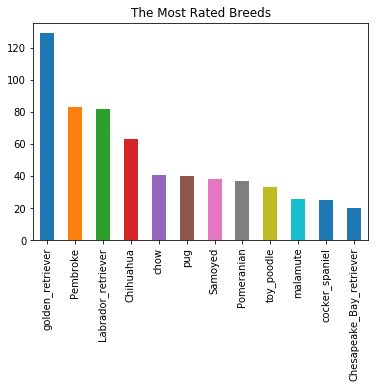

In [7]:
top = weRateDogsArchive_clean.groupby('p1').filter(lambda x: len(x) >= 20)
top['p1'].value_counts().plot(kind = 'bar')
plt.title('The Most Rated Breeds');